https://www.thepythoncode.com/article/use-transfer-learning-for-image-flower-classification-keras-python

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2, ResNet50, InceptionV3 # try to use them and see which is better
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

import numpy as np

In [16]:
batch_size = 32

num_classes = 10

epochs = 10

IMAGE_SHAPE = (224, 224, 3)

In [17]:
def load_data():
    # count how many images are there
    image_count = len(list(glob.glob('pose_image/*/*.jpg')))
    print("Number of images:", image_count)

    CLASS_NAMES = np.array([item.split('\\')[1] for item in glob.glob('pose_image/*')])

    # 20% validation set 80% training set
    image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2)
    # make the training dataset generator
    train_data_gen = image_generator.flow_from_directory(directory='./pose_image', batch_size=batch_size,
                                                        classes=list(CLASS_NAMES), target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
                                                        shuffle=True, subset="training")
    # make the validation dataset generator
    test_data_gen = image_generator.flow_from_directory(directory='./pose_image', batch_size=batch_size, 
                                                        classes=list(CLASS_NAMES), target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
                                                        shuffle=True, subset="validation")
    return train_data_gen, test_data_gen, CLASS_NAMES

In [18]:
def create_model(input_shape):
    # load MobileNetV2
    model = MobileNetV2(input_shape=input_shape)
    # remove the last fully connected layer
    model.layers.pop()
    # freeze all the weights of the model except the last 4 layers
    for layer in model.layers[:-4]:
        layer.trainable = False
    # construct our own fully connected layer for classification
    output = Dense(num_classes, activation="softmax")
    # connect that dense layer to the model
    output = output(model.layers[-1].output)
    model = Model(inputs=model.inputs, outputs=output)
    # print the summary of the model architecture
    model.summary()
    # training the model using adam optimizer
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [19]:
# load the data generators
train_generator, validation_generator, class_names = load_data()
# constructs the model
model = create_model(input_shape=IMAGE_SHAPE)
# model name
model_name = "MobileNetV2_finetune_last5"
# some nice callbacks
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
checkpoint = ModelCheckpoint(os.path.join("results", f"{model_name}" + "-loss-{val_loss:.2f}.h5"),
                            save_best_only=True,
                            verbose=1)
# make sure results folder exist
if not os.path.isdir("results"):
    os.mkdir("results")
# count number of steps per epoch
training_steps_per_epoch = np.ceil(train_generator.samples / batch_size)
validation_steps_per_epoch = np.ceil(validation_generator.samples / batch_size)
# train using the generators
model.fit_generator(train_generator, steps_per_epoch=training_steps_per_epoch,
                    validation_data=validation_generator, validation_steps=validation_steps_per_epoch,
                    epochs=epochs, verbose=1, callbacks=[tensorboard, checkpoint])

Number of images: 9772
Found 7823 images belonging to 10 classes.
Found 1949 images belonging to 10 classes.
14540800/14536120 [==============================] - 27s 2us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (B

Epoch 1/10
  1/245 [..............................] - ETA: 0s - loss: 2.3023 - accuracy: 0.1250WARNING:tensorflow:From C:\Users\user\.conda\envs\AIschool\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
245/245 [==============================] - ETA: 0s - loss: 2.0427 - accuracy: 0.7653
Epoch 00001: val_loss improved from inf to 1.86193, saving model to results\MobileNetV2_finetune_last5-loss-1.86.h5
245/245 [==============================] - 157s 639ms/step - loss: 2.0427 - accuracy: 0.7653 - val_loss: 1.8619 - val_accuracy: 0.8363
Epoch 2/10
245/245 [==============================] - ETA: 0s - loss: 1.6483 - accuracy: 0.8241
Epoch 00002: val_loss improved from 1.86193 to 1.55151, saving model to results\MobileNetV2_finetune_last5-loss-1.55.h5
245/245 [==============================] - 155s 631ms/step - 

In [21]:
# load the data generators
train_generator, validation_generator, class_names = load_data()
# constructs the model
model = create_model(input_shape=IMAGE_SHAPE)
# load the optimal weights
model.load_weights("results/MobileNetV2_finetune_last5-loss-0.47.h5")
validation_steps_per_epoch = np.ceil(validation_generator.samples / batch_size)
# print the validation loss & accuracy
evaluation = model.evaluate_generator(validation_generator, steps=validation_steps_per_epoch, verbose=1)
print("Val loss:", evaluation[0])
print("Val Accuracy:", evaluation[1])

Number of images: 9772
Found 7823 images belonging to 10 classes.
Found 1949 images belonging to 10 classes.
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0] 

61/61 [==============================] - 28s 459ms/step - loss: 0.4672 - accuracy: 0.8830
Val loss: 0.4672023057937622
Val Accuracy: 0.8830169439315796


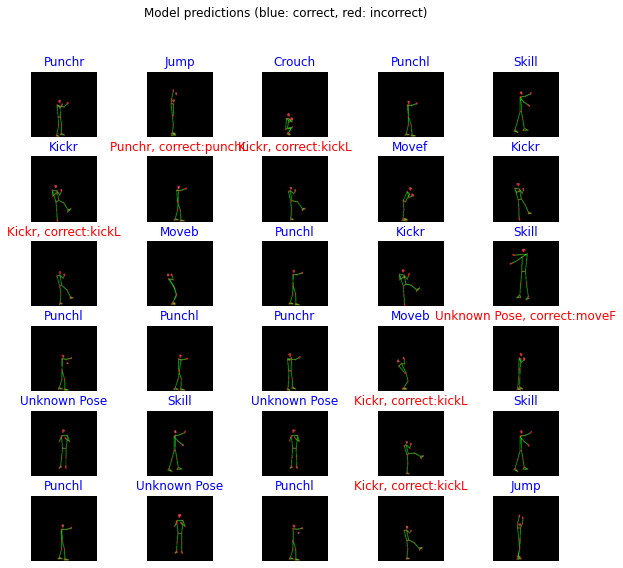

In [23]:
import matplotlib.pyplot as plt

# get a random batch of images
image_batch, label_batch = next(iter(validation_generator))
# turn the original labels into human-readable text
label_batch = [class_names[np.argmax(label_batch[i])] for i in range(batch_size)]
# predict the images on the model
predicted_class_names = model.predict(image_batch)
predicted_ids = [np.argmax(predicted_class_names[i]) for i in range(batch_size)]
# turn the predicted vectors to human readable labels
predicted_class_names = np.array([class_names[id] for id in predicted_ids])
# some nice plotting
plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    if predicted_class_names[n] == label_batch[n]:
        color = "blue"
        title = predicted_class_names[n].title()
    else:
        color = "red"
        title = f"{predicted_class_names[n].title()}, correct:{label_batch[n]}"
    plt.title(title, color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")
plt.show()

In [3]:
pip install tensorflowjs

Note: you may need to restart the kernel to use updated packages.


In [8]:
import tensorflowjs as tfjs

loaded_model = tf.keras.models.load_model('./results/MobileNetV2_finetune_last5-loss-0.47.h5')
tfjs.converters.save_keras_model(loaded_model, './jsModel/')